In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2a5wmoq3
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2a5wmoq3
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267007 sha256=83a4bd57f8290556758a49c4e1f52dbf5cc6c3521b412deb6a7700c4dd2570c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-cjh2w7_s/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundat

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [3]:
pip install wandb

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import json
import os
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog  
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

1.5.0+cu101 True


In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset')
# data paths
# train_path = os.path.join(data_path, 'train') 
# test_path = os.path.join(data_path, 'test')
# val_path = os.path.join(data_path, 'validation')

train_path = os.path.join(data_path, 'train_small') 
test_path = os.path.join(data_path, 'test_small')
val_path = os.path.join(data_path, 'validation_small')

# label files
# with open(os.path.join(data_path, 'train.json')) as f:
#     train_labels = json.load(f)
# with open(os.path.join(data_path, 'test.json')) as f:
#     test_labels = json.load(f)
# with open(os.path.join(data_path, 'val.json')) as f:
#     val_labels = json.load(f)

with open(os.path.join(data_path, 'train_small.json')) as f:
    train_labels = json.load(f)
with open(os.path.join(data_path, 'test_small.json')) as f:
    test_labels = json.load(f)
with open(os.path.join(data_path, 'val_small.json')) as f:
    val_labels = json.load(f)

In [0]:
# need to change image path and set bbox_mode to 
for ind, elem in enumerate(train_labels):
    train_labels[ind]['file_name'] = os.path.join(train_path, train_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(train_labels[ind]['annotations']):
        train_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

for ind, elem in enumerate(test_labels):
    test_labels[ind]['file_name'] = os.path.join(test_path, test_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(test_labels[ind]['annotations']):
        test_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS
  
for ind, elem in enumerate(val_labels):
    val_labels[ind]['file_name'] = os.path.join(val_path, val_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(val_labels[ind]['annotations']):
        val_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

In [8]:
val_labels[0] # detectron2 style labels

{'annotations': [{'bbox': [107.051008,
    173.038848,
    899.9751679999999,
    660.432384],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation_small/01bef5827cab386c.jpg',
 'height': 768,
 'image_id': '01bef5827cab386c',
 'width': 1024}

In [0]:
# returns dataset
def get_data_dicts(d):
    if d == 'train':
        return train_labels
    elif d == 'val':
        return val_labels
    elif d == 'test':
        return test_labels

# register dataset
for d in ["train", "val", "test"]:
    DatasetCatalog.register("data_" + d, lambda d=d: get_data_dicts(d))

    # large dataset
    # MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch',
    #                                                     'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi',
    #                                                     'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow',
    #                                                     'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool',
    #                                                     'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack'])
    
    # small dataset
    MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Coffeemaker', 'Gas Stove']).set(evaluator_type='coco')

data_metadata = MetadataCatalog.get("data_train")

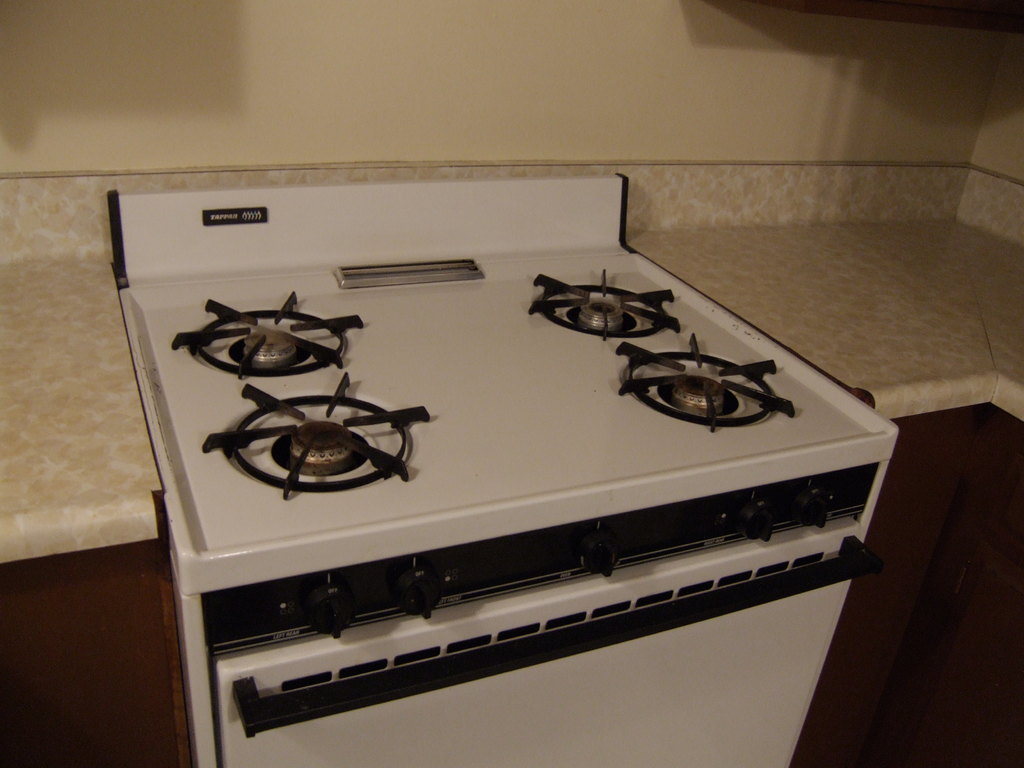

In [10]:
im = cv2.imread(os.path.join(val_path, os.listdir(val_path)[0]))
cv2_imshow(im)

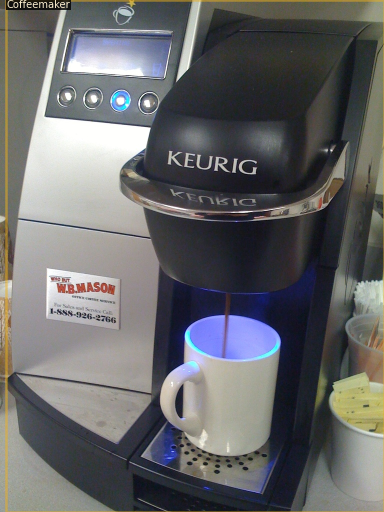

In [11]:
img = cv2.imread(os.path.join(val_path, os.listdir(val_path)[3]))
visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(val_labels[3])
cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
val_labels[5]

{'annotations': [{'bbox': [0.1536, 0.0, 760.109056, 678.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation_small/2540d6d0d881c2ba.jpg',
 'height': 678,
 'image_id': '2540d6d0d881c2ba',
 'width': 1024}

In [0]:
def visualize(image_path):
    img = cv2.imread(image_path)
    visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(val_labels[5])
    cv2_imshow(vis.get_image()[:, :, ::-1])

**Training Model**

In [0]:
#!wandb login

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import wandb
import yaml

import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel


import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import (
    COCOEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter,
)

In [0]:
# from detectron2.engine import DefaultTrainer
# from detectron2.config import get_cfg

# cfg = get_cfg()
# cfg.OUTPUT_DIR = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output')
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.DATASETS.TRAIN = ("data_train",)
# cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 0
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [0]:
# detectron2 models
# FPN = Feature Pyramid Network
# RPN = Region Proposal Network
# 3x learning rate scheduler tend to perform better compared to 1x learning rate scheduler
# FPN: Use a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff, but the other two are still useful for research.

# Full Model Description: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

models_to_try = {'R50-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
                 'R101-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
                 'RN-50-3x': 'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
                 'RN-101-3x': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'}

In [0]:
# Current configuration
cfg = get_cfg()
cfg.OUTPUT_DIR = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output')
cfg.merge_from_file(model_zoo.get_config_file(models_to_try['R50-FPN-3x']))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(models_to_try['R50-FPN-3x']) # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # small dataset has 3 classes
cfg.TEST.EVAL_PERIOD = 100
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# cfg.DATASETS.TEST = ("data_val", )


logger = logging.getLogger("detectron2")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [19]:
# write config file to local
f = open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'config.yaml'), "w")
f.write(cfg.dump())
f.close()

config_dict = None

with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'config.yaml'), "r") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    config_dict = yaml.load(file, Loader=yaml.FullLoader)

wandb.init(project="amenity_object_detection", sync_tensorboard=True, config = config_dict)

W&B Run: https://app.wandb.ai/jsantoso2/amenity_object_detection/runs/3w2h0afe

In [0]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type

    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, cfg, True, output_folder))

    if len(evaluator_list) == 1:
        return evaluator_list[0]
    
    return DatasetEvaluators(evaluator_list)


#     # evaluator = COCOEvaluator("data_val", cfg, False, output_dir="./output/")
#     # val_loader = build_detection_test_loader(cfg, "data_val")
#     # inference_on_dataset(model, val_loader, evaluator)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        #evaluator = COCOEvaluator("data_val", cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name))
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


def do_train(cfg, model, resume=False):
    model.train()
    optimizer = build_optimizer(cfg, model)
    scheduler = build_lr_scheduler(cfg, optimizer)

    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    start_iter = (
        checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
    )
    max_iter = cfg.SOLVER.MAX_ITER

    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )

    writers = (
        [
            CommonMetricPrinter(max_iter),
            JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
            #TensorboardXWriter(cfg.OUTPUT_DIR),
        ]
        if comm.is_main_process()
        else []
    )

    # compared to "train_net.py", we do not support accurate timing and
    # precise BN here, because they are not trivial to implement
    data_loader = build_detection_train_loader(cfg)
    logger.info("Starting training from iteration {}".format(start_iter))
    with EventStorage(start_iter) as storage:
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            iteration = iteration + 1
            storage.step()

            loss_dict = model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            # print('Losses_reduced', losses_reduced)
            # print('Loss_dict_reduced', loss_dict_reduced)

            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()


            # log in weights and biases
            stored = loss_dict_reduced
            stored['total_loss'] = sum(loss for loss in loss_dict_reduced.values())
            stored['learn_rate'] = optimizer.param_groups[0]["lr"]

            wandb.log(stored, step = iteration)

            if (
                cfg.TEST.EVAL_PERIOD > 0
                and iteration % cfg.TEST.EVAL_PERIOD == 0
                #and iteration != max_iter
            ):
                # does checkpointing every test.eval.period
                # checkpointer = DetectionCheckpointer(model, save_dir=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output', 'checkpoint'))
                # checkpointer.save("model_" + str(iteration))  # save to output/model_999.pth

                cfg.MODEL.WEIGHTS = optimizer.param_groups[0]["weight_decay"]
                cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
                cfg.DATASETS.TEST = ("data_val", )

                train_eval = do_test(cfg, model)
                wandb.log(train_eval, step = iteration)

                # Compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
                for writer in writers:
                    writer.write()

            periodic_checkpointer.step(iteration)


# def setup(args):
#     """
#     Create configs and perform basic setups.
#     """
#     cfg = get_cfg()
#     cfg.merge_from_file(args.config_file)
#     cfg.merge_from_list(args.opts)
#     cfg.freeze()
#     default_setup(
#         cfg, args
#     )  # if you don't like any of the default setup, write your own setup code
#     return cfg


def main(cfg):
    #cfg = setup(args)

    model = build_model(cfg)
    logger.info("Model:\n{}".format(model))
    # if test == True:
    #     DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    #         cfg.MODEL.WEIGHTS, resume = False #resume=args.resume
    #     )
    #     return do_test(cfg, model)

    distributed = comm.get_world_size() > 1
    if distributed:
        model = DistributedDataParallel(
            model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
        )

    do_train(cfg, model, resume = False) #resume=args.resume)

    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    cfg.DATASETS.TEST = ("data_val", )
    predictor = DefaultPredictor(cfg)

    return do_test(cfg, model)

# if __name__ == "__main__":
#     args = default_argument_parser().parse_args()
#     print("Command Line Args:", args)
#     launch(
#         main,
#         args.num_gpus,
#         num_machines=args.num_machines,
#         machine_rank=args.machine_rank,
#         dist_url=args.dist_url,
#         args=(args,),
#     )

In [21]:
main(cfg)

[05/23 18:41:26 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.


[05/23 18:41:26 d2.data.build]: Removed 0 images with no usable annotations. 1237 images left.
[05/23 18:41:26 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category   | #instances   |  category  | #instances   |
|:----------:|:-------------|:-----------:|:-------------|:----------:|:-------------|
|  Bathtub   | 545          | Coffeemaker | 323          | Gas Stove  | 526          |
|            |              |             |              |            |              |
|   total    | 1394         |             |              |            |              |
[05/23 18:41:26 d2.data.common]: Serializing 1237 elements to byte tensors and concatenating them all ...
[05/23 18:41:26 d2.data.common]: Serialized dataset takes 0.37 MiB
[05/23 18:41:26 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/23 18:41:26 d2

OrderedDict([('bbox',
              {'AP': 37.74151153261876,
               'AP-Bathtub': 45.23050093470885,
               'AP-Coffeemaker': 42.43893146306116,
               'AP-Gas Stove': 25.555102200086253,
               'AP50': 71.86374080140308,
               'AP75': 36.67615108006589,
               'APl': 37.802732132452945,
               'APm': nan,
               'APs': nan})])

In [0]:
tmp = OrderedDict([('bbox', {'AP': 0.013628949096077201, 'AP50': 0.05218506526452711, 'AP75': 0.0, 'APs': np.nan, 'APm': np.nan, 'APl': 0.02088430672115052, 'AP-Bathtub': 0.0, 'AP-Coffeemaker': 0.0408868472882316, 'AP-Gas Stove': 0.0})])

In [24]:
tmp['bbox']

{'AP': 0.013628949096077201,
 'AP-Bathtub': 0.0,
 'AP-Coffeemaker': 0.0408868472882316,
 'AP-Gas Stove': 0.0,
 'AP50': 0.05218506526452711,
 'AP75': 0.0,
 'APl': 0.02088430672115052,
 'APm': nan,
 'APs': nan}

In [0]:
# inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("data_test", )
predictor = DefaultPredictor(cfg)

# evaluate
evaluator = COCOEvaluator("data_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "data_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [0]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output